In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

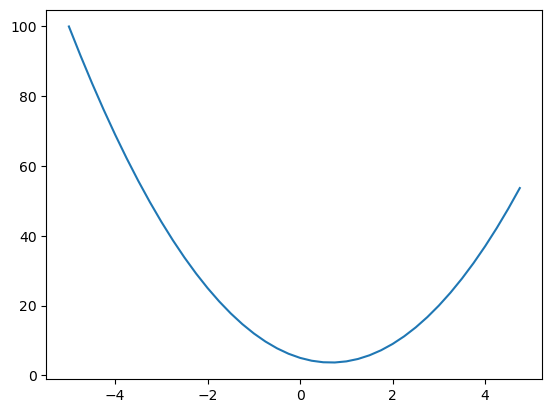

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [8]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
(d2 - d1) / h

-2.999999981767587

In [9]:
class Value():
    
    # Initialize the data using 'Value()' data structure
    def __init__(self, data, sub_value=(), op="", label=""):
        self.data = data
        self.prev = set(sub_value)
        self._backward = lambda: None
        self.op = op
        self.label = label
        self.grad = 0  # no effect
    
    # Output the value when called
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Negation of the 'Value()' data type
    def __neg__(self):
        return self * -1
    
    # Add two distinct 'Value()' data types
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)    # add any int values to Value
        out = Value(self.data + other.data, (self, other), op="+")
        
        # Backpropogate addition function to find the gradient of the previous nodes
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    # Reverse the data and add when necessary (primary data type + Value() data type)
    def __radd__(self, other):    # other + self
        return self + other
    
    # Subtract two distinct 'Value()' data types
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)    # subtract any int values to Value
        out = Value(self.data - other.data, (self, other), op="-")
        
        # Backpropogate subtraction function to find the gradient of the previous nodes
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    # Reverse the data and subtract when necessary (primary data type - Value() data type)
    def __radd__(self, other):    # other - self
        return self - other
    
    # Multiply two distinct 'Value()' data types
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)    # multiply any int values to Value
        out = Value(self.data * other.data, (self, other), op="*")
        
        # Backpropogate addition function to find the gradient of the previous nodes
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out
    
    # Raise the data to the power
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        # Backpropogate power function to find the gradient of the previous nodes
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    # Reverse the data and multiply when necessary (primary data type * Value() data type)
    def __rmul__(self, other):    # other * self
        return self * other
    
    # Divide two distinct 'Value()' data types
    def __truediv__(self, other):
        return self * other**-1
    
    # Find the tanh() of the neuron [gives the activation number]
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        # Backpropogate tanh function to find the gradient of the previous nodes
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
#     def exp(self):
#         x = self.data
#         out = Value(math.exp(x), (self, ), 'exp')
        
#         def _backward():
#             self.grad += out.data * out.grad    # as famously, the derivative of e^x remains the same
#         out._backward = _backward
        
#         return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out    
    
    def backward(self):
        # implementing topoligical sort
        topo = []
        visited = ()
        def build_topo(v):
            if v not in visited:
                for sub in v.prev:
                    build_topo(sub)
                topo.append(v)
        build_topo(self)
        topo
        
        # Base case
        self.grad = 1.0
        # calling it for all the previous values for backpropogating
        for node in reversed(topo):
            node._backward()


In [10]:
a = Value(2.0)
b = Value(4.0)

To find the gradient of 'L' with respect to any variable, apply: 

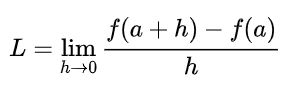

To find the gradient of 'L' with respect to any variable, apply (**chain rule**): 

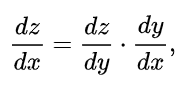

Since `tanh()` is a hyperbolic function, it has to be implemented seperately inside a `def func`.

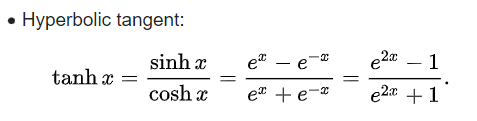

As we know, when backpropogating the grad function, `+` is the basically the flow of the current gradient to the gradient of the previous connecting nodes. Here, the nodes that are directly connected to `n` will have the same gradient function as `n`.

Here, the nodes that are directly connected to `x1w1x2w2` will have the same gradient function as `x1w1x2w2`.

In the case of multiplication `*`, assuming there are 2 values (`w1`, `x1`) whose product is the next node (`x1w1`), the gradient of one value (`x1.grad`, `w1.grad`) will be the product of the gradient of the result node (`x1w1.grad`) and the value of the other (`w1.data`, `x1.data`) respectively.

The same will be done for the other 2 nodes (`w2`, `x2`).

The gradient of these values is the derivative of the `grad` value, i.e., derivative of `tanh()` function.

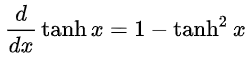

Implementation of topoligical sorting for automating backpropogation of gradients (implemented above).

<img src="https://miro.medium.com/v2/resize:fit:1400/1*uMg_ojFXts2WZSjcZe4oRQ.png" alt="Image" width="300" height="300">

**Code:**
```
# Base case
o.grad = 1.0

# implementing topoligical sort
topo = []
visited = ()
def build_topo(v):
    if v not in visited:
        for sub in v.prev:
            build_topo(sub)
        topo.append(v)
build_topo(o)
topo

# calling it for all the previous values for backpropogating
for node in reversed(topo):
    node._backward()
```

In [11]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n.op, label = n.op)
            # and connect this node to it
            dot.edge(uid + n.op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

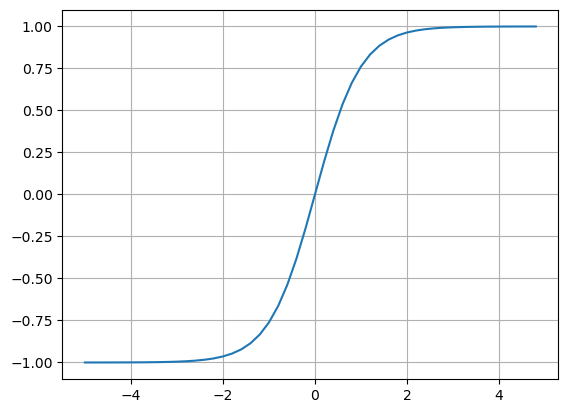

In [12]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [13]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Neuron (without activation function)
n = x1w1x2w2 + b; n.label = 'n'

# take the neuron through the activation function (tanh()) and give the output
o = n.tanh(); o.label = 'o'

In [14]:
o.backward()

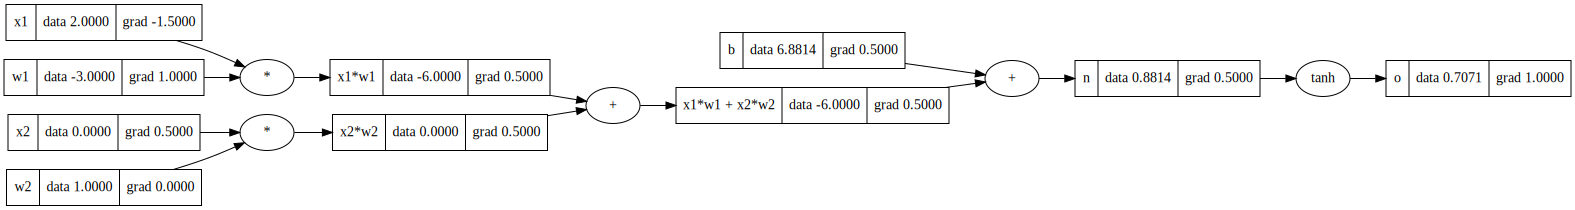

In [15]:
draw_dot(o)

### Backpropogation on the same data using Pytorch

In [16]:
import torch

In [17]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


#### Building a neural net library (multi-layer perceptron)

Essentially, a neural network is made up of Neurons in Multiple Layers connected to one another.

Architecture of a Neuron.

<img src="../images/neuron_model.jpeg" alt='neuron model' width=300>

A single layer of neurons is called a perceptron.

<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--lO32pEOv--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_800/https://raw.githubusercontent.com/DrakeEntity/project-Image/master/1_8VSBCaqL2XeSCZQe_BAyVA.jpeg" alt="perceptron" width=300>

A Multi-layer Perceptron, also called A Neural Network.

<img src="../images/neural_net2.jpeg" alt="Multi Layer Perceptron" width=300>

In [18]:
# to make a single neuron
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)    # w * x + b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]


# to make a Layer of Neurons
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    
# to make a multi-layer perceptron
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [19]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.16315816304337405)

In [20]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

y_preds = [n(x) for x in xs]
y_preds

[Value(data=0.16315816304337405),
 Value(data=0.7378588971977703),
 Value(data=0.2992967685592946),
 Value(data=0.2854782731632216)]

Evidently, the output values `y_preds` are not the same as the 'desired targets' we wanted.

To stop this from happening, we have to find the `loss` of the output.

To stop this from happening, we have to find the loss of the output and reduce is by tuning the hyperparameters.

In [21]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_preds))
loss

Value(data=5.919171197560828)

In [44]:
# setting the gradient descent manually
for k in range(20):
    
    # forward pass
    y_preds = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_preds))    # Loss function used here is "Mean Squared Error"
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, "->", loss.data)


0 -> 0.010385074269091344
1 -> 0.010215254630209038
2 -> 0.010167628439649924
3 -> 0.010108939140983037
4 -> 0.010052289378705911
5 -> 0.010018025225287965
6 -> 0.009987678617100206
7 -> 0.009952488599421517
8 -> 0.00990868009245779
9 -> 0.00987625081477659
10 -> 0.009812284347181616
11 -> 0.009776763902767271
12 -> 0.00972228244124522
13 -> 0.009561083574435924
14 -> 0.009527954191806808
15 -> 0.009500343628450876
16 -> 0.009469459525835345
17 -> 0.009429009322740597
18 -> 0.009380646840258976
19 -> 0.009326653469206974


In [45]:
y_preds

[Value(data=0.9606110187392745),
 Value(data=-0.9519915197914288),
 Value(data=-0.9560305637898722),
 Value(data=0.9405270134273054)]